<a href="https://colab.research.google.com/github/jcmachicao/modpred__evaluacion/blob/main/nn_pnp_delitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ruta = 'drive/My Drive/2020 data/'

In [ ]:
data = pd.read_excel(ruta + 'bd_soldeoro_pnp.xlsx')
data.info()

In [6]:
descartar = ['id_doc_denuncia', 'FECHA_HECHO', 'FECHA_REGISTRO', 'COMISARIA', 'UBICACIÓN', 'SUBTIPO', 'DEPARTAMENTO', 'PROVINCIA']
data = data.drop(descartar, axis=1)
data.columns

Index(['MATERIA', 'TIPO', 'MODALIDAD', 'DISTRITO', 'TIPO DE VIA', 'SITUACION',
       'GENERO'],
      dtype='object')

In [7]:
var_cat, var_num = [], []
for a, b in zip(data.columns, data.dtypes):
    if b == 'object':
      var_cat.append(a)
    else:
      var_num.append(a)
print(var_cat)
print(var_num)

['MATERIA', 'TIPO', 'MODALIDAD', 'DISTRITO', 'TIPO DE VIA', 'SITUACION', 'GENERO']
[]


In [8]:
data[var_cat].apply(lambda x: x.value_counts()).T.stack()

MATERIA    FUERO COMUN                    3043.0
           HECHOS DE INTERES POLICIAL    16099.0
           LEYES ESPECIALES               3380.0
           NIÑOS Y ADOLESCENTES             10.0
           TRANSITO                       1091.0
                                          ...   
SITUACION  SOLICITANTE                    1928.0
           TESTIGO                          26.0
           VICTIMA                         138.0
GENERO     F                             10033.0
           M                             13590.0
Length: 252, dtype: float64

In [9]:
data_cat = pd.get_dummies(data[var_cat], drop_first=True)
#data_num = data[var_num]
#X_df = pd.concat([data_cat, data_num], axis=1)
X_df = data_cat.to_numpy()
#scl = MinMaxScaler()
#scl.fit(X_df)
#X = scl.transform(X_df).astype('float')
#X.shape, type(X)

In [10]:
for col in data.columns:
    print(col, len(data[col].unique()))

MATERIA 5
TIPO 22
MODALIDAD 149
DISTRITO 32
TIPO DE VIA 10
SITUACION 32
GENERO 2


In [11]:
d20 = pd.get_dummies(data[['MATERIA', 'TIPO', 'MODALIDAD', 'DISTRITO', 'TIPO DE VIA', 'GENERO']], drop_first=True)

In [12]:
X = d20.to_numpy().astype(float)
X.shape

(23623, 214)

In [13]:
y = data.SITUACION.factorize()[0]
y

array([ 0,  1,  1, ..., 12,  3,  1])

In [14]:
X_tn = torch.from_numpy(X.astype(float))
y_tn = torch.from_numpy(y.reshape(-1,1).astype(float))

In [15]:
X_tn.shape, y_tn.shape

(torch.Size([23623, 214]), torch.Size([23623, 1]))

In [16]:
model = torch.nn.Sequential(
  torch.nn.Linear(X_tn.shape[1], X_tn.shape[0]),
  torch.nn.ReLU(),
  torch.nn.Linear(X_tn.shape[0], 264),
  torch.nn.Dropout(p=0.15, inplace=False),
  torch.nn.ReLU(),
  torch.nn.Linear(264, 32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 1)
)

In [17]:
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'Tesla T4')

In [18]:
model.cuda()
X_g = X_tn.cuda()
y_g = y_tn.cuda()

In [19]:
optimizador = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
criterio = torch.nn.MSELoss()

In [21]:
errores = []
nit = 0

In [36]:
EPOCS = 2000

In [37]:
preds = []
nit += 1
for epo in range(EPOCS):
    optimizador.zero_grad()
    y_pred = model(X_g.float())
    loss = criterio(y_pred, y_g.float())
    loss.backward()
    optimizador.step()
    if epo % 500 == 0:
        print(epo, loss.item())
        errores.append([epo+nit*EPOCS, loss.item()])
        pred = y_pred.cpu().detach().numpy()
        preds.append(pred)

500 7.228166103363037
1000 7.22619104385376
1500 7.224984645843506


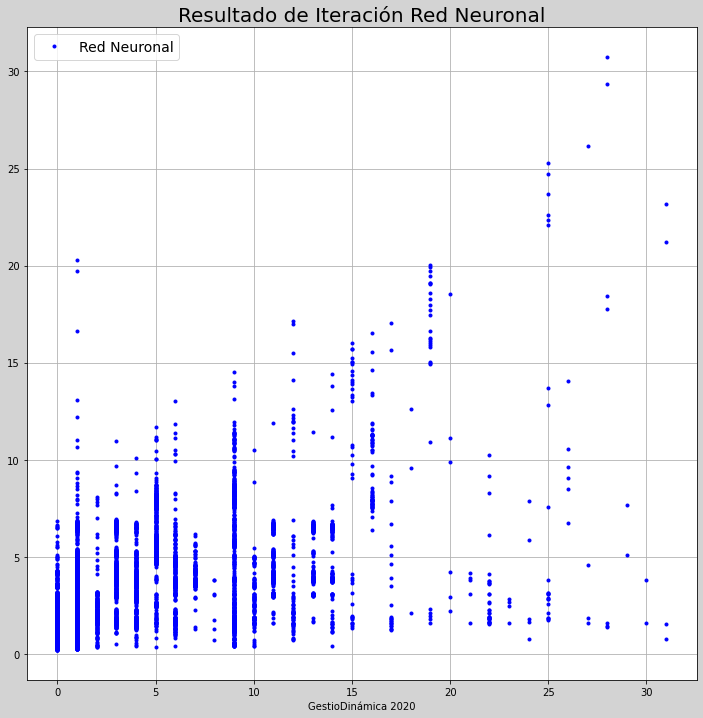

In [39]:
plt.figure(figsize=(12,12), facecolor='lightgray')
plt.plot(y, pred, 'bo', ms=3, label='Red Neuronal')
plt.title('Resultado de Iteración Red Neuronal', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.xlabel('GestioDinámica 2020')
plt.grid(True, which='both')
plt.show()

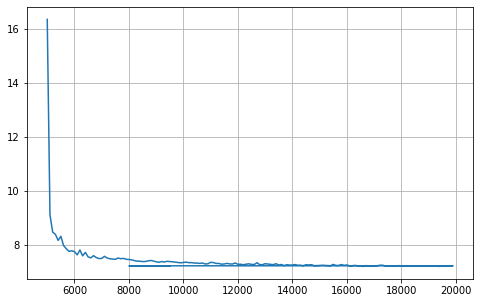

In [40]:
err_df = pd.DataFrame(errores)
plt.figure(figsize=(8,5), facecolor='white')
plt.plot(err_df[0], err_df[1])
plt.grid(True)
plt.show()

In [41]:
torch.save(model.state_dict(), ruta + 'pnp_32situaciones.tar')

https://pytorch.org/tutorials/beginner/saving_loading_models.html

